# Mandoor Machine Learning Model

## Importing Libraries
- `pandas`, `numpy`: For data manipulation and numerical operations.
- `pad_sequences`: To pad input sequences to a uniform length.
- `Model`, `layers`: For building and defining the neural network model in Keras.
- `Adam`: The Adam optimizer for model training.
- `train_test_split`: For splitting the data into training and test sets.
- `matplotlib.pyplot`: For data visualization and plotting.

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models

## Function to Create Encoding Dictionaries

This function generates an encoding dictionary and an encoded sequence for a given list of user inputs.

In [2]:
# Function to create encoding dictionaries dynamically for services and locations
def create_encoding_dict(user_input):
    encoding_dict = {item: idx for idx, item in enumerate(user_input)}
    encoded_sequence = [encoding_dict[item] for item in user_input]
    return encoding_dict, encoded_sequence

# Function to normalize input between 0 and 1 (input 1-5 to normalized 0-1)
def normalize_input(user_input, min_value=1, max_value=5):
    return (user_input - min_value) / (max_value - min_value)


## Loading and Encoding Dataset

This section of the code performs the following operations:
- Loads a dataset from a CSV file.
- Extracts unique services and locations.
- Encodes services and locations as indices.

In [4]:
# URL of the CSV file on GitHub
file_url = 'https://raw.githubusercontent.com/Man-door/Machine-Learning/main/dataset/data_final.csv'

# Load the dataset from the URL
dataset = pd.read_csv(file_url)

# Extract services and locations from the dataset
unique_services = list(set([service.strip() for sublist in dataset['layanan_lain'].apply(eval).tolist() for service in sublist]))
unique_locations = list(set([loc.strip() for sublist in dataset['jangkauan'].apply(eval).tolist() for loc in sublist]))

# Encode services and locations from the dataset
service_to_idx = {service: idx for idx, service in enumerate(unique_services)}
location_to_idx = {loc: idx for idx, loc in enumerate(unique_locations)}

# Encode services and locations as indices in the dataset
dataset['layanan_indices'] = dataset['layanan_lain'].apply(
    lambda x: [service_to_idx[service.strip()] for service in eval(x)]
)
dataset['location_indices'] = dataset['jangkauan'].apply(
    lambda x: [location_to_idx[loc.strip()] for loc in eval(x)]
)


## Padding Services and Locations and Extracting Features

This section of the code pads service and location sequences to a fixed length and extracts specific features.

In [5]:
# Pad services and locations to a fixed length
X_services = pad_sequences(dataset['layanan_indices'], maxlen=10, padding='post')
X_locations = pad_sequences(dataset['location_indices'], maxlen=10, padding='post')

# Extract the `rating_user`, `pengalaman`, and `portofolio` as features
X_rating_user = dataset['rating_user'].values
X_pengalaman = dataset['pengalaman'].values
X_portofolio = dataset['portofolio'].values


## Simulating User Preferences and Preparing Input Data

This code simulates user preferences based on various input features and prepares them for model input.

In [6]:
# Simulate user preferences based on services, locations, rating, pengalaman, and portofolio

input_layanan = ["plafon","pemasangan atap"]
input_lokasi = ["jakarta"]
input_rating_user = 4  # User input between 1-5
input_pengalaman = 5  # User input for pengalaman (between 1-5)
input_portofolio = 2  # User input for portofolio (between 1-5)

# Normalize user input for rating, pengalaman, and portofolio to fit dataset's normalized range (0-1)
input_rating_user_normalized = normalize_input(input_rating_user)
input_pengalaman_normalized = normalize_input(input_pengalaman)
input_portofolio_normalized = normalize_input(input_portofolio)

# Create encoding for services and locations based on user input
service_to_idx, encoded_services = create_encoding_dict(input_layanan)
location_to_idx, encoded_locations = create_encoding_dict(input_lokasi)

# Pad the encoded services and locations for user input
X_services_input = pad_sequences([encoded_services], maxlen=10, padding='post')
X_locations_input = pad_sequences([encoded_locations], maxlen=10, padding='post')

# Prepare the normalized user rating_user, pengalaman, and portofolio as numerical inputs
X_rating_user_input = np.array([[input_rating_user_normalized]])
X_pengalaman_input = np.array([[input_pengalaman_normalized]])
X_portofolio_input = np.array([[input_portofolio_normalized]])


## Splitting the Data into Training and Validation Sets

This part of the code splits the features into training and validation sets using `train_test_split`.

In [7]:
# Split data into training and validation sets (we'll use services, locations, rating_user, pengalaman, and portofolio)
X_train_services, X_val_services, X_train_locations, X_val_locations, X_train_rating_user, X_val_rating_user, X_train_pengalaman, X_val_pengalaman, X_train_portofolio, X_val_portofolio = train_test_split(
    X_services, X_locations, X_rating_user, X_pengalaman, X_portofolio, test_size=0.2, random_state=42
)


## Building the Model

Defines a model with embeddings for services and locations, concatenates additional features (rating, experience, portfolio), and outputs a relevance score.

In [8]:
# Build the model (we'll now include the pengalaman and portofolio in the prediction)
service_input = Input(shape=(10,), name='service_input')
service_embedding = Embedding(input_dim=len(unique_services), output_dim=8)(service_input)
service_embedding = Flatten()(service_embedding)

location_input = Input(shape=(10,), name='location_input')
location_embedding = Embedding(input_dim=len(unique_locations), output_dim=8)(location_input)
location_embedding = Flatten()(location_embedding)

rating_user_input = Input(shape=(1,), name='rating_user_input')
pengalaman_input = Input(shape=(1,), name='pengalaman_input')
portofolio_input = Input(shape=(1,), name='portofolio_input')

# Concatenate service, location, rating_user, pengalaman, and portofolio
concatenated = Concatenate()([service_embedding, location_embedding, rating_user_input, pengalaman_input, portofolio_input])

# Dense layers
dense1 = Dense(128, activation='relu')(concatenated)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(1, activation='linear', name='relevance_score')(dense2)


## Compiling the Model

This section compiles the model, specifying the optimizer (`Adam`), loss function (`mse`), and evaluation metric (`mae`). It also displays the model summary.


In [9]:
# Compile the model
model = Model(
    inputs=[
        service_input, 
        location_input, 
        rating_user_input, 
        pengalaman_input, 
        portofolio_input
        ], 
    outputs=output)

model.compile(
    optimizer=Adam(), 
    loss='mse', 
    metrics=['mae'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ service_input       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ location_input      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 10, 8)     │        608 │ service_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 10, 8)     │      3,528 │ location_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 80)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 80)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rating_user_input   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pengalaman_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ portofolio_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 163)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ rating_user_inpu… │
│                     │                   │            │ pengalaman_input… │
│                     │                   │            │ portofolio_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     20,992 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relevance_score     │ (None, 1)         │         65 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,449 (130.66 KB)

 Trainable params: 33,449 (130.66 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

This part trains the model using the training data (`X_train_services`, `X_train_locations`, etc.), with dummy relevance scores. It runs for 50 epochs, with a batch size of 32, and includes validation data for performance evaluation.


In [10]:
# Train the model
history = model.fit(
    [X_train_services, X_train_locations, X_train_rating_user, X_train_pengalaman, X_train_portofolio],
    np.ones(X_train_services.shape[0]),  # Dummy relevance score for training
    epochs=50,
    batch_size=32,
    validation_data=([X_val_services, X_val_locations, X_val_rating_user, X_val_pengalaman, X_val_portofolio], np.ones(X_val_services.shape[0])),  # Dummy relevance score for validation
    verbose=1
)


Epoch 1/50


d:\BANGKIT\TensorJS\tfvenv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['service_input', 'location_input', 'rating_user_input', 'pengalaman_input', 'portofolio_input']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5262 - mae: 0.6388 - val_loss: 0.1030 - val_mae: 0.2745
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0654 - mae: 0.2122 - val_loss: 0.0151 - val_mae: 0.0973
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - mae: 0.0661 - val_loss: 0.0048 - val_mae: 0.0489
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - mae: 0.0397 - val_loss: 0.0032 - val_mae: 0.0363
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mae: 0.0285 - val_loss: 0.0024 - val_mae: 0.0292
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6219e-04 - mae: 0.0214 - val_loss: 0.0020 - val_mae: 0.0268
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3453e-04 - mae: 0.0163 - val_loss: 0.0019 - val_mae: 0.0253
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6143e-04 - mae: 0.0149 - val_loss: 0.0018 - val_mae: 0.0227
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6338e-04 -

## Plotting Training & Validation MAE and Loss

This section plots the training and validation MAE and loss values over epochs.

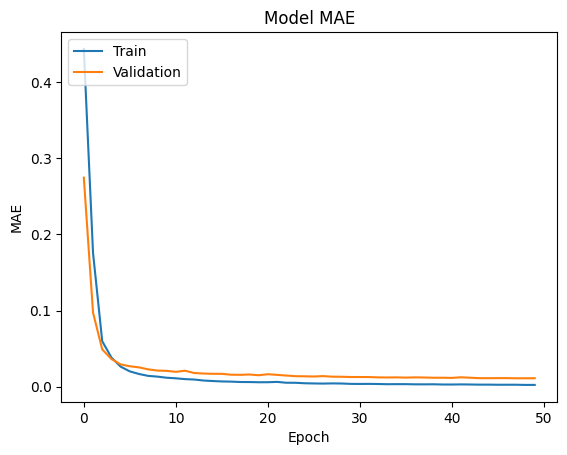

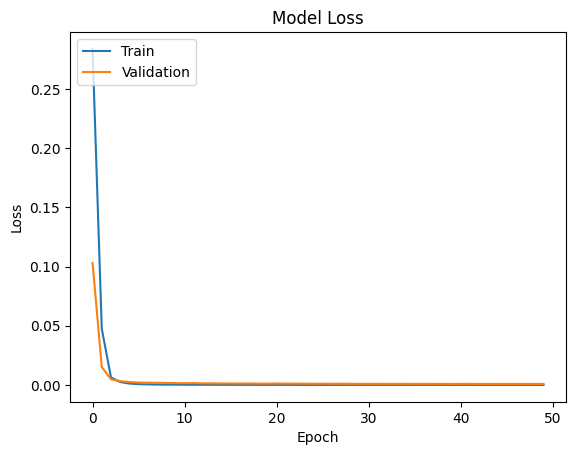

In [11]:
# Plot training & validation MAE values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Predicting Relevance Score

This section predicts the relevance score for user input by feeding the normalized input features into the model and displaying the predicted value.

In [12]:
# Predict relevance for the user input
prediksi_relevance = model.predict([X_services_input, X_locations_input, np.array([[input_rating_user_normalized]]), np.array([[input_pengalaman_normalized]]), np.array([[input_portofolio_normalized]])])

# Display the predicted relevance score for the user input
print(f"Predicted Relevance Score: {prediksi_relevance[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Predicted Relevance Score: 0.94805508852005


## Predicting and Displaying Top 10 Recommended Vendors

This part of the code predicts the relevance scores for all vendors in the dataset, ranks them based on the scores, and displays the top 10 recommended vendors along with their details.


In [13]:
# Predict relevance scores for all vendors in the dataset (based on services, locations, rating_user, pengalaman, and portofolio)
dataset['predicted_relevance'] = model.predict([X_services, X_locations, X_rating_user, X_pengalaman, X_portofolio])

# Get the top 10 recommended vendors based on relevance score
top_vendors = dataset.nlargest(10, 'predicted_relevance')[['name', 'predicted_relevance', 'jangkauan', 'layanan_lain']]

# Display the top 10 recommended vendors
print("\nTop 10 Recommended Vendors:")
print(top_vendors)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Top 10 Recommended Vendors:
                                            name  predicted_relevance  \
697                        Nauffal  jaya mandiri             1.028980   
359                           Winto Mandiri Jaya             1.026266   
332                               Mitra solution             1.020000   
101                            Hengki Kontraktor             1.018444   
289  Sandi ( MEP )Electrical Mechanical plumbing             1.017442   
30                  CV CAGAK SURYA MANDIRI (CSM)             1.017379   
808                                Khanza teknik             1.017099   
309                              EKO BENING JAYA             1.016697   
231                                Abdi Building             1.014547   
716                          Mitra Karya Pandawa             1.014532   

                                             jangkauan  \
697  ['Jakarta Barat', 'Pemalang', 'Jakarta Timur',...   
359  ['Jakar

### Saving the Model in h5 Format

In [17]:
# Save the model in H5 format
model.save('ML_model.h5')

### Saving the Model in tflite Format

In [18]:
import tensorflow as tf

# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('ML_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\LWNOVO\AppData\Local\Temp\tmpojttvzhp\assets


INFO:tensorflow:Assets written to: C:\Users\LWNOVO\AppData\Local\Temp\tmpojttvzhp\assets


Saved artifact at 'C:\Users\LWNOVO\AppData\Local\Temp\tmpojttvzhp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 10), dtype=tf.float32, name='service_input'), TensorSpec(shape=(None, 10), dtype=tf.float32, name='location_input'), TensorSpec(shape=(None, 1), dtype=tf.float32, name='rating_user_input'), TensorSpec(shape=(None, 1), dtype=tf.float32, name='pengalaman_input'), TensorSpec(shape=(None, 1), dtype=tf.float32, name='portofolio_input')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2029064553488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2029064683152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2029064555408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2029064556368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2029064553296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2029064555984: TensorSpec(shape=(), dtype=tf.resource, nam